# Topicando (AlPHA)
Topicando es un proyecto que busca ayudar a obtener los tópicos más comentados por un grupo de personas, obteniendo palabras clave en forma de ranking y grafos, para poder analizar necesidades, reclamos, comentarios, tendencias e ideas de la comunidad de forma masiva.

En base a un array de frases como input se procesarán y analizarán los datos recolectados para poder tener un contexto de un tema de debate o discusión, siendo asi que:
- Presenta en una lista ordenada de mayor a menor las palabras más utilizadas diferenciadas con stemming o lemmatizing
- En base a las x palabras más usadas escogidas por estadistica o por número fijo, se crean clusters con KNN, KMeans, etc o solo con que contengan a esta palabra y se muestran grafos por cada palabra elegida como centroide
- De cada cluster o agrupación se debe mostrar las palabras más usadas

## Imports

In [1]:
import spacy
from unidecode import unidecode
from string import punctuation 
from nltk.corpus import stopwords
from collections import Counter
from spacy.matcher import Matcher
import pandas as pd
import numpy as np

In [28]:
class TopicandoV1:
    nlp = None
    phrases = []
    entities = []
    relations = []
    dictWords = {}
    
    def __init__(self, spacyLang, phrases):
        self.nlp = spacy.load(spacyLang)
        self.phrases = phrases
        self.entities = []
        self.relations = []
        self.dictWords = {}
    
    def getVectorizedPhrases(self):
        values = []
        for phrase in self.phrases:
            vector = np.zeros(300)
            doc = self.nlp(phrase)
            for token in doc:
                if not token.is_stop and not token.is_punct:
                    #print(token.text, token.pos_, token.dep_) #eliminar det
                    vector = vector + np.array(token.vector_norm)
            values.append(vector / len(doc))
        return np.array(values)

    def getMostUsedWordsInCorpus(self, useLemma = True):
        fullText = ""
        for phrase in self.phrases:
            fullText += (phrase + " ")
        doc = self.nlp(fullText)

        words = [(token.lemma_ if useLemma else token.text)
            for token in doc
            if not token.is_stop and not token.is_punct]

        word_freq = Counter(words)
        common_words = word_freq.most_common()
        return common_words
    
    def getWordCountOfEntitiesAndRelations(self):
        dictWords = {}
        for entitiesPair in self.entities:
            for word in entitiesPair:
                if word not in dictWords.keys():
                    dictWords[word] = 1
                else:
                    dictWords[word] += 1
        for relations in self.relations:
            for word in relations:
                if word not in dictWords.keys():
                    dictWords[word] = 1
                else:
                    dictWords[word] += 1

        self.dictWords = dictWords
        return dictWords

    def getMostUsedWordsOfEntitiesAndRelations(self, useLemma = True):
        self.getWordCountOfEntitiesAndRelations()
        return dict(sorted(self.dictWords.items(), key=lambda item: item[1], reverse=True))
    
    def searchEntitiesAndRelations(self):
        self.entities = []
        for phrase in self.phrases:
            self.entities.append(self.__getEntities(phrase))
        
        self.relations = []
        for phrase in self.phrases:
            self.relations.append(self.__getRelations(phrase))
    
    def getSourceEdgeTargetDataFrame(self,sourcesToSearch=[], edgesToSearch=[], targetsToSearch=[]):
        phraseLength = len(self.entities)
        sources = []
        targets = []
        edges = []
        
        for index in range(0, phraseLength):
            for relation in self.relations[index]:
                source = self.entities[index][0]
                target = self.entities[index][1]

                if (len(sourcesToSearch) + len(targetsToSearch) + len(edgesToSearch)) == 0 or (relation in edgesToSearch or source in sourcesToSearch or target in targetsToSearch):
                    sources.append(self.entities[index][0])
                    targets.append(self.entities[index][1])
                    edges.append(relation)

        sourceEdgeTargetDataframe = pd.DataFrame({'source':sources, 'target':targets, 'edge':edges})
        return sourceEdgeTargetDataframe
    def __getRelations(self, phrase):
        doc = self.nlp(phrase)

        matcher = Matcher(self.nlp.vocab)
        pattern = [
            {'POS':'VERB','OP':"?"},
            {'POS':'AUX','OP':"?"},
        ]

        matcher.add("matching_1", [pattern]) 
        matches = matcher(doc)

        if len(matches) == 0:
            return ["haber"]

        return [doc[match[1]:match[2]].lemma_ for match in matches]

    def __getEntities(self, phrase):
        ent1 = ""
        ent2 = ""

        prv_tok_dep = ""    
        prv_tok_text = ""   

        prefix = ""
        modifier = ""

        prv_token = None

        tokens = []

        for tok in self.nlp(phrase):
            if tok.dep_ != "punct":
                if tok.dep_ == "compound":
                    prefix = tok.text
                if prv_tok_dep == "compound":
                    prefix = prv_tok_text + " "+ tok.text
                if tok.dep_.endswith("mod") == True:
                    modifier = tok.text
                if prv_tok_dep == "compound":
                    modifier = prv_tok_text + " "+ tok.text
                if (tok.dep_.find("subj") == True or tok.dep_ == "subj") and tok.pos_ != "PRON":
                    ent1 = modifier + " " + prefix + " "+ tok.lemma_
                    prefix = ""
                    modifier = ""
                    prv_tok_dep = ""
                    prv_tok_text = ""
                    tokens.append(ent1)
                if tok.dep_.find("obj") == True:
                    ent2 = modifier + " " + prefix + " " + tok.lemma_
                    tokens.append(ent2)
                if tok.dep_ == "obj":
                    ent2 = tok.lemma_
                    tokens.append(ent2)
                if ent1.strip() == "" and ent2.find(tok.lemma_) == -1:
                    if tok.dep_.find("mod") == True and tok.pos_ == "ADJ":
                        ent1 = tok.lemma_
                        tokens.append(ent1)
                    if tok.pos_ == "NOUN":
                        ent1 = tok.lemma_
                        tokens.append(ent1)
                if ent2.strip() == "" and ent1.find(tok.lemma_) == -1:
                    if tok.dep_.find("mod") == True and tok.pos_ == "ADJ":
                        ent2 = tok.lemma_
                        tokens.append(ent2)
                    if tok.pos_ == "ADJ":
                        ent2 = tok.lemma_
                        tokens.append(ent2)
                    if tok.pos_ == "NOUN":
                        ent2 = tok.lemma_
                        tokens.append(ent2)
                    if (prv_token != None and prv_token.pos_ == "AUX") and (tok.pos_ == "VERB" or tok.pos_ == "ADJ"):
                        ent2 = tok.lemma_
                        tokens.append(ent2)
                prv_tok_dep = tok.dep_
                prv_tok_text = tok.text
                prv_token = tok

        #return [token.strip() for  token in tokens]
        return [ent1.strip(), ent2.strip()]

In [3]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import scipy

In [4]:
from sklearn.cluster import KMeans
import numpy as np

## Data

In [5]:
phrases = [
    "No hay baños limpios",
    "los baños no se limpian",
    "los baños están sucios",
    "los vecinos hacen mucho ruido",
    "la vecina todo el día grita",
    "la vecina grita todo el día",
    "el vecino prende la radio todo el día",
    "ya no hay respeto a los mayores",
    "me acosan en la calle del barrio",
    "los viejos miran mucho mi cuerpo",
    "morbosean a mis familiares",
    "los viejos son pervertidos",
    "las calles están sucias",
    "ya no hay calles limpias",
    "los perros dañan la basura",
    "hay muchos perros que dejan sus desechos en la calle",
    "mucha mierda de perro en la acera",
]

In [29]:
data = pd.read_csv('./sugerencias-y-quejas-de-los-ciudadanos (1).csv',delimiter=';')
data = data.dropna()
data[data['Referencia'].apply(lambda x: isinstance(x, (str, bytes)))]
phrases = [ phrase.lower() for phrase in data.iloc[:,6].values]

## Functions

In [30]:
topicando = TopicandoV1("es_core_news_lg",phrases)

In [31]:
vectorizedPhrases = topicando.getVectorizedPhrases()

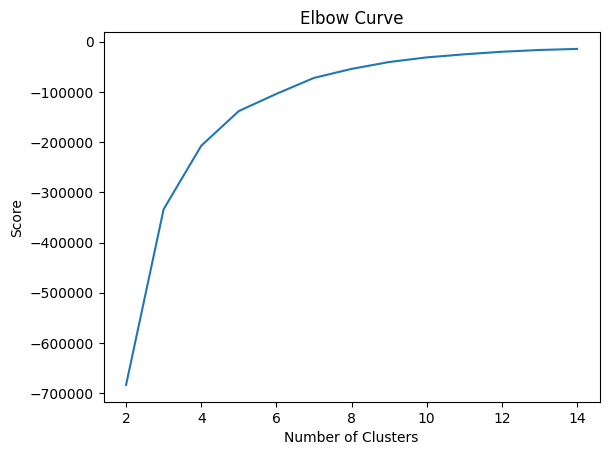

In [32]:
Nc = range(2, 15)
kmeans = [KMeans(n_clusters = i) for i in Nc]
kmeans
score = [kmeans[i].fit(vectorizedPhrases).score(vectorizedPhrases) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [33]:
nGroups = 6
kmeans = KMeans(n_clusters= nGroups, random_state=0).fit(vectorizedPhrases)

In [34]:
labels = kmeans.labels_
labels

array([2, 5, 5, 5, 4, 5, 0, 3, 1, 5, 3, 3, 1, 4, 3, 2, 2, 0, 0, 1, 5, 3,
       2, 1, 5, 5, 1, 1, 5, 3, 1, 3, 5, 4, 1, 2, 1, 1, 3, 0, 5, 4, 4, 2,
       2, 1, 0, 2, 1, 5, 4, 1, 2, 1, 3, 0, 4, 2, 3, 1, 2, 5, 1, 3, 0, 4,
       2, 5, 3, 2, 3, 2, 5, 2, 3, 5, 2, 2, 2, 5, 1, 5, 2, 1, 2, 5, 1, 5,
       4, 5, 4, 1, 4, 5, 1, 0, 2, 5, 1, 5, 2, 2, 4, 2, 1, 1, 1, 2, 1, 3,
       4, 5, 4, 2, 2, 0, 1, 0, 5, 1, 2, 1, 2, 2, 3, 2, 1, 3, 0, 4, 3, 5,
       1, 3, 4, 5, 1, 5, 5, 1, 5, 2, 4, 1, 4, 4, 5, 5, 1, 5, 1, 0, 1, 5,
       4, 4, 5, 4, 5, 5, 2, 1, 2, 5, 5, 4, 2], dtype=int32)

In [20]:
cluster_centers = kmeans.cluster_centers_

In [35]:
phrasesPorGrupo = []
for index in range(0,nGroups):
    phrasesPorGrupo.append([])

for index in range(0,len(labels)):
    for catIndex in range(0,nGroups):
        if labels[index] == catIndex:
            phrasesPorGrupo[catIndex].append(phrases[index])

In [36]:
phrasesPorGrupo[0]

['cita',
 'paso peatonal',
 'solicita mejora señalizacion horizontal cl 517',
 'mejorar tramitación electrónica',
 'cierre camino vecinal',
 'mejoras tecnológicas ámbito rural',
 'cierre camino público',
 'limpieza solar',
 'licencia ambiental',
 'sistema operativo móvil ios',
 'falta contestación escrito',
 'queja actuaciones cámara propiedad urbana fianza']

In [37]:
phrasesPorGrupo[1]

['exigencia de uso de navegador internet explorer para trámites electrónicos',
 'darse de alta en bec mediante sistema cl@ve',
 'el interesa sugiere abaratar precios del transporte del tren de cercanías de segovia-madrid',
 'alegaciones a la plantilla de respuestas del primer ejercicio de la oposición para acceso al cuerpo de policía local',
 'la interesada se queja de eliminación de líneas regulares de transporte público en santa mª la real de nieva',
 'desacuerdo con asignación de cotos sobrantes de pesca en salamanca',
 'mejora carretera cl-501 entrada pueblo la adrada',
 'se requiere contestación y aportación documentos relacionados en el "solicita" del escrito de 22 de noviembre de 2021',
 'el interesado denuncia situcación de la ocupación por roturación de vias pecuarias',
 'mal funcionamiento nuevo sistema de notificaciones electrónicas.',
 'solicitud de servicio de autobús a escuela capacitación agraria segovis',
 'notificación electrónica. enlace al nuevo sistema de notificaci

In [38]:
phrasesPorGrupo[2]

['falta de respuesta a solicitud',
 'queja relacionada con la presentada el día 8 noviembre 2021',
 'falta de aviso en notificaciones electrónicas',
 'modificación de normativa de pesca para el año 2022 para los embalses de pontón alto y puente alta (sg)',
 'incumplimiento normativa de acampada',
 'incorporar sistema cl@ve para trámites administrativos',
 'limpieza cañada de ganado',
 'falta de información en notificaciones electrónicas',
 'cierre alerta 112 sin contactar con menor que llamó al 112',
 'señales de carretera incorrectas',
 'mal funcionamiento aplicacvión permisos pesca',
 'demora en otorgar vivienda proteccion oficial por violencia de género',
 'atencion deficiente territorial de medio ambiente valladolid',
 'carteles aparcamiento carbanas playa pita',
 'no atención telefónica',
 'señal luminosa no funciona de noche',
 'paso de camiones por carretera inapropiada',
 'limpieza cunetas carretera cl-602',
 'falta de atención en la sección de vivienda pública',
 'alta velocid

In [39]:
phrasesPorGrupo[3]

['incidencias en la carretera za-504, que ha sido recientemente rehabilitada',
 'no usar las mascarillas en el lugar de trabajo',
 'señalización en entrada carretera a peñaranda de bracamonte',
 'que en medio ambiente no ha sido atendida.',
 'no satisfecho con contestación envíada a queja anterior',
 'la interesada se queja de retrasos en la línea arévalo-nava de la asunción-segovia',
 'los pasales de madera del puente se encuentran en un estado ruinoso',
 'deasignación permiso arec',
 'queja por mal estado carretera tordillos',
 'el iteresado sugiere que se de una solución al estado, lamentable, de la carretera sg-322',
 'el interesado se queja porque se ha asfaltado mal un agujero en la carretera',
 'la interesada propone nueva ubiación de los autobuses',
 'reiteración mal estado rejilla crta. va-223',
 'mal estado de la señalización vertical en la bu-532',
 'disconformidad con la contestación dada a la q-14457',
 'mal estado de carretera',
 'mal estado de la carretera autónomica cl-

In [40]:
phrasesPorGrupo[4]

['buzón notificaciones electrónicas',
 'notificaciones electrónicas',
 'obligacion relacionarse electrónicamente',
 'petición mejora plataformas junta cyl',
 'colocación badenes',
 'unificación criterios en sede electrónica',
 'imposibilidad contacto telefónico',
 'pide que atiendan de forma presencial',
 'falta de luz en carretera autonomica',
 'notificaciones electrónicas',
 'mala conservación carretera fompedraza',
 'falta de atención',
 'falta cobertura internet y telefonía móvil',
 'solicitud devolución pagos cotos pesca por cierre perimetral',
 'señalización comienzo pueblo',
 'trato inadecuado agente medioambiental',
 'mal estado márgenes río tormes',
 'información insuficiente para anulación permisos pesca',
 'devolución importe licencia de caza temporada 2020/2021',
 'dificultad en tramitación electrónica para solicitar tarjeta club de los 60',
 'derecho a trámites electrónicos',
 'cebos utilizados para pesca',
 'diámetro escaso tuberías agua za-925']

In [41]:
phrasesPorGrupo[5]

['notificaciones sin indicación del titular al que van dirigidas',
 'solicita revisión de altura máxima de edificación en la cisterniga (vallladolid)',
 'normas subsidiarias municikpales consistente en la modificacion el ambito desarrolo del area especial ae.ps-4 y re¡mision a la comision de urbanismo.',
 'no funciona la máquina de bonos de transporte de la estación de autobuses',
 'transporte a la demanda. merindades',
 'reacondicionamiento camino navarredondilla a navatalgordo',
 'el interesado se queja de la eliminación de líneas de trasporte en santa mª la real de nieva',
 'la interesada se queja de la supresión de líneas de transporte en santa mª la real de nieva',
 'rechazada y derivada a servicios centrales  por ser competencia del 112 (fomento y medio ambiente)',
 'el interesado teme riesgo de inundaciones por estado de puentes en madrona',
 'mal funcionamiento formulario para presentar telematicamente para medioambiente valladolid',
 'retraso autobus de santervas de campos',
 